Using device: cuda
Loading datasets...
Test samples: 2807

Evaluating model: MambaOut_1token
Loading checkpoint from Comparing_Mambas_Trans/gated_cnn_(mambaout)_1_token.pth
Number of parameters: 1,048,856,631
Model size: 4001.07 MB


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 23.07it/s]



Test Metrics:
  Loss: 0.0635
  Accuracy: 0.9802
  Micro F1: 0.6485
  Macro F1: 0.4402
  Weighted F1: 0.6332
  Macro AUROC: 0.9365813634206961

Evaluating model: MambaOut_19_18token
Loading checkpoint from Comparing_Mambas_Trans/gated_cnn_(mambaout)_balanced.pth
Number of parameters: 1,042,237,495
Model size: 3975.82 MB


Evaluating: 100%|██████████| 11/11 [00:07<00:00,  1.40it/s]



Test Metrics:
  Loss: 0.0695
  Accuracy: 0.9773
  Micro F1: 0.5710
  Macro F1: 0.3919
  Weighted F1: 0.5514
  Macro AUROC: 0.9180171013253607

Evaluating model: MambaOut_522_18token
Loading checkpoint from Comparing_Mambas_Trans/gated_cnn_(mambaout)_max_tokens.pth
Number of parameters: 589,799,479
Model size: 2249.91 MB


Evaluating: 100%|██████████| 11/11 [01:06<00:00,  6.00s/it]



Test Metrics:
  Loss: 0.0597
  Accuracy: 0.9728
  Micro F1: 0.4159
  Macro F1: 0.3172
  Weighted F1: 0.3864
  Macro AUROC: 0.9195925788431726

Evaluating model: Transformer_1token
Loading checkpoint from Comparing_Mambas_Trans/transformer_1_token.pth
Number of parameters: 1,048,487,991
Model size: 4079.67 MB


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 24.87it/s]



Test Metrics:
  Loss: 0.0643
  Accuracy: 0.9786
  Micro F1: 0.6127
  Macro F1: 0.4297
  Weighted F1: 0.5969
  Macro AUROC: 0.9232279644766381

Evaluating model: Transformer_19_18token
Loading checkpoint from Comparing_Mambas_Trans/transformer_balanced.pth
Number of parameters: 1,041,377,335
Model size: 4052.55 MB


Evaluating: 100%|██████████| 11/11 [00:07<00:00,  1.54it/s]



Test Metrics:
  Loss: 0.0677
  Accuracy: 0.9771
  Micro F1: 0.6051
  Macro F1: 0.4219
  Weighted F1: 0.5981
  Macro AUROC: 0.8928486679737621

Evaluating model: Transformer_522_18token
Loading checkpoint from Comparing_Mambas_Trans/transformer_max_tokens.pth
Number of parameters: 585,713,719
Model size: 2294.33 MB


Evaluating: 100%|██████████| 11/11 [01:00<00:00,  5.48s/it]



Test Metrics:
  Loss: 0.0706
  Accuracy: 0.9688
  Micro F1: 0.3313
  Macro F1: 0.2608
  Weighted F1: 0.3028
  Macro AUROC: 0.8713998243405207
Model families:
  MambaOut: ['MambaOut_1token', 'MambaOut_19_18token', 'MambaOut_522_18token']
  Transformer: ['Transformer_1token', 'Transformer_19_18token', 'Transformer_522_18token']
  Mamba2: []

Results saved to model_comparison_20250428_123239/
Summary: model_comparison_20250428_123239/model_family_summary.csv
Summary report generated: model_comparison_20250428_123239/summary_report.txt


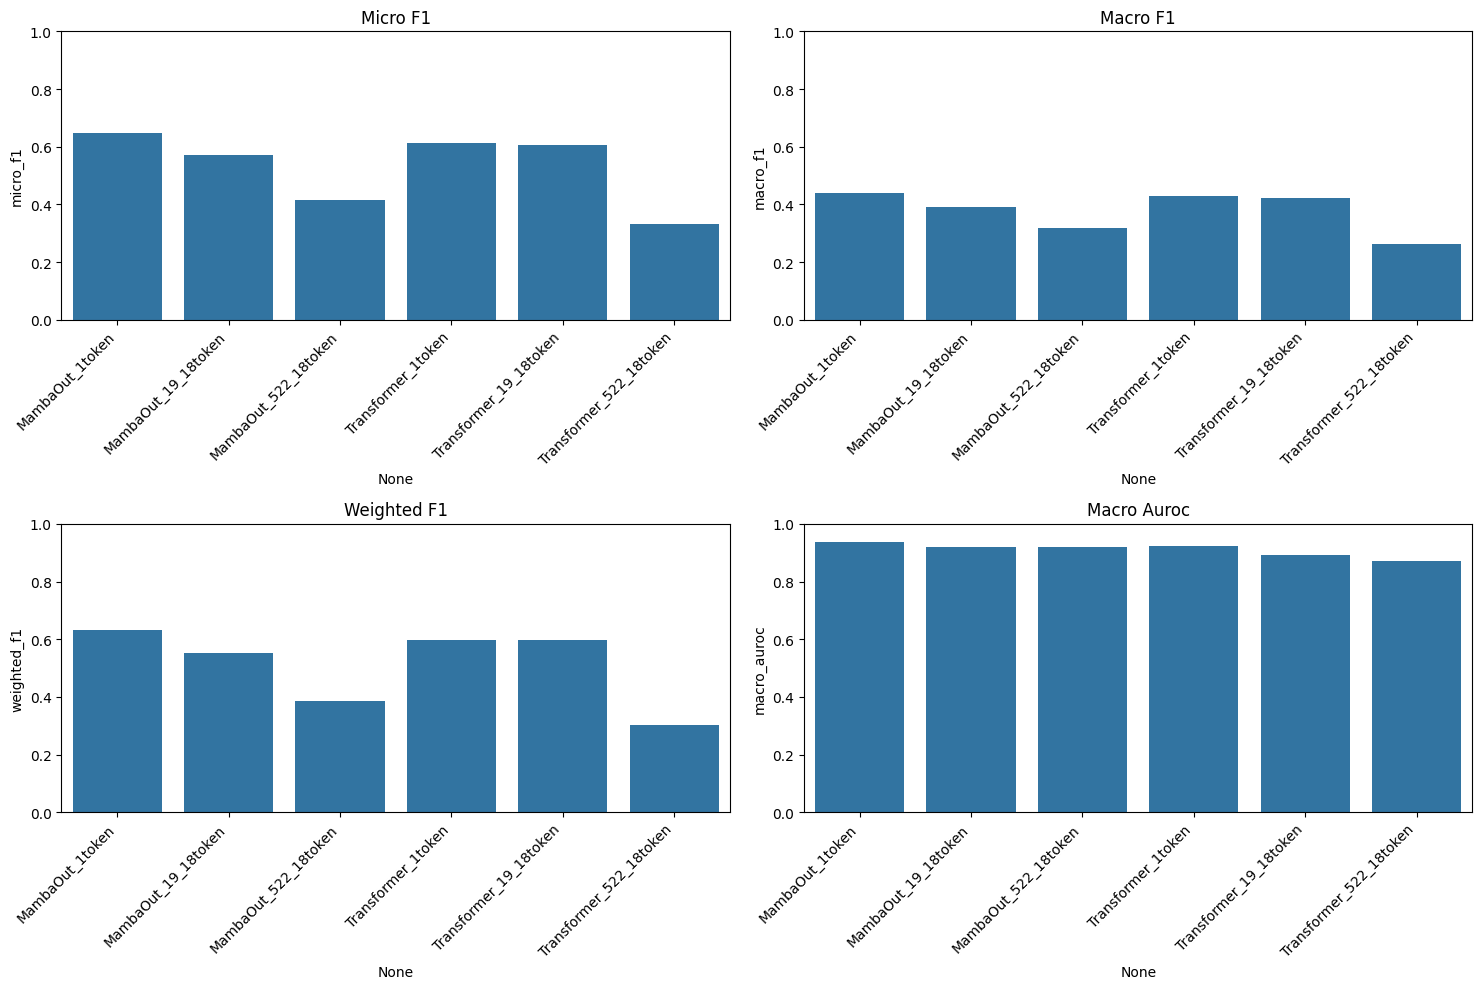

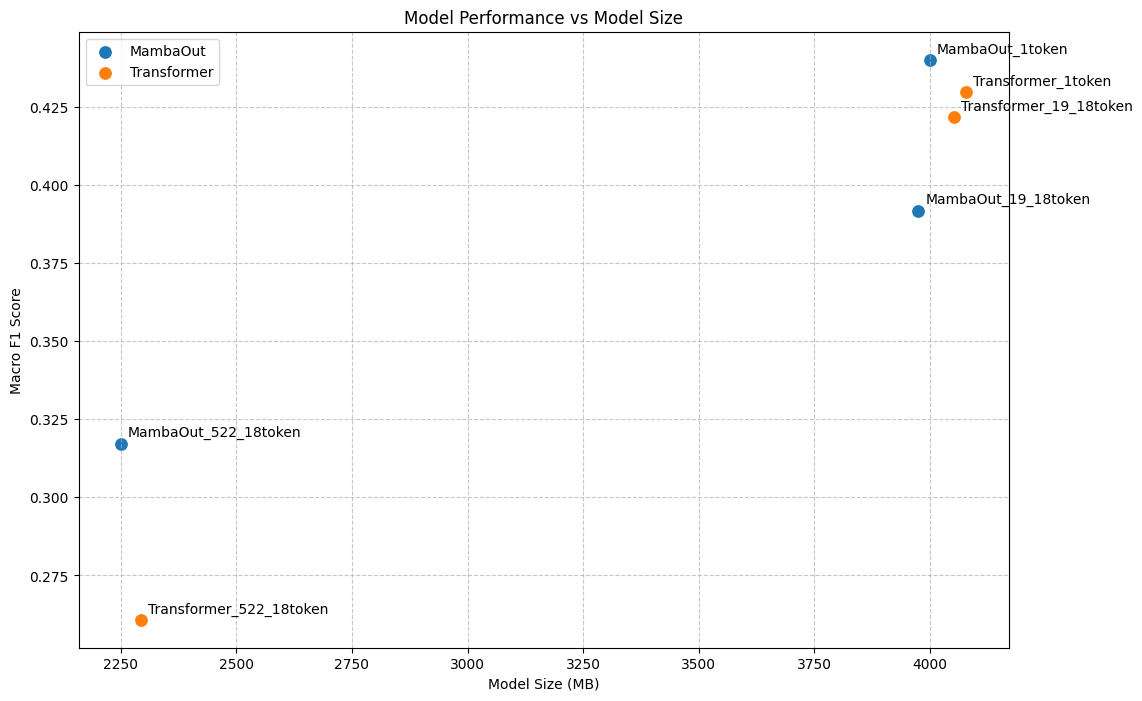

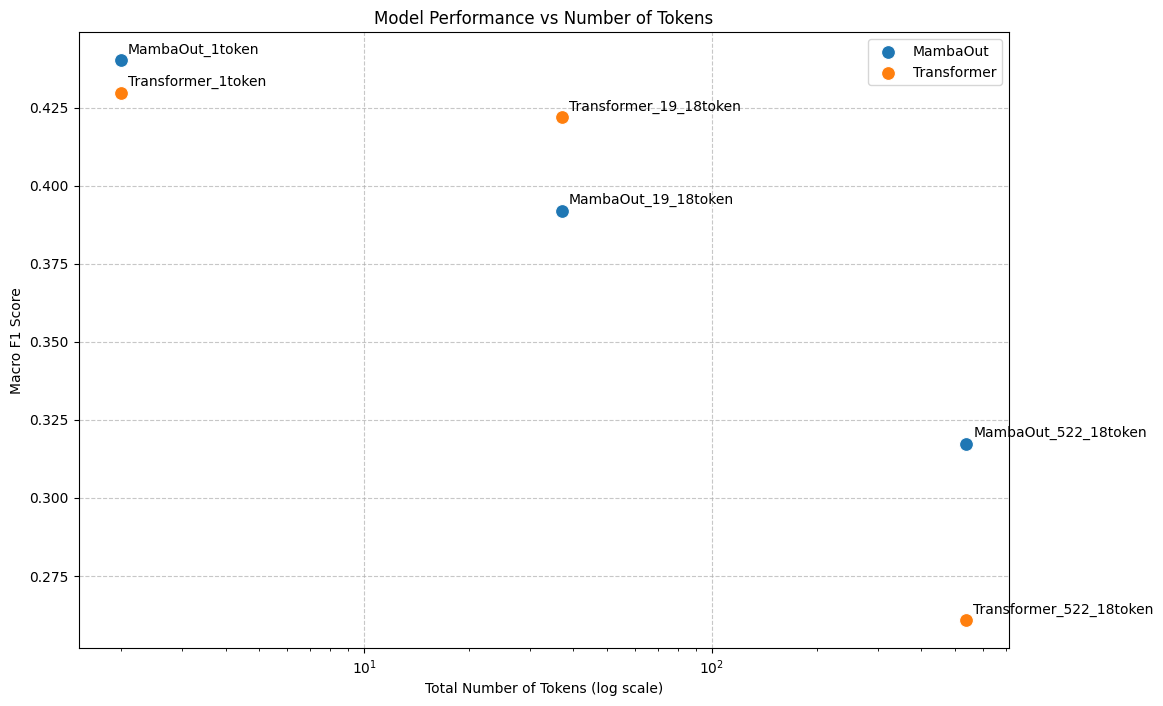

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, roc_auc_score, average_precision_score
import os
import json
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import pickle
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score


# Import your model architectures
from Fusion_Models import StarClassifierFusionMambaOut, StarClassifierFusionTransformer, StarClassifierFusionMambaTokenized

class MultiModalBalancedMultiLabelDataset(Dataset):
    """
    A balanced multi-label dataset that returns (X_spectra, X_gaia, y).
    It uses the same balancing strategy as `BalancedMultiLabelDataset`.
    """
    def __init__(self, X_spectra, X_gaia, y, limit_per_label=201):
        """
        Args:
            X_spectra (torch.Tensor): [num_samples, num_spectra_features]
            X_gaia (torch.Tensor): [num_samples, num_gaia_features]
            y (torch.Tensor): [num_samples, num_classes], multi-hot labels
            limit_per_label (int): limit or target number of samples per label
        """
        self.X_spectra = X_spectra
        self.X_gaia = X_gaia
        self.y = y
        self.limit_per_label = limit_per_label
        self.num_classes = y.shape[1]
        self.indices = self.balance_classes()
        
    def balance_classes(self):
        indices = []
        class_counts = torch.sum(self.y, axis=0)
        for cls in range(self.num_classes):
            cls_indices = np.where(self.y[:, cls] == 1)[0]
            if len(cls_indices) < self.limit_per_label:
                if len(cls_indices) == 0:
                    # No samples for this class
                    continue
                extra_indices = np.random.choice(
                    cls_indices, self.limit_per_label - len(cls_indices), replace=True
                )
                cls_indices = np.concatenate([cls_indices, extra_indices])
            elif len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        indices = np.unique(indices)
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return (
            self.X_spectra[index],  # spectra features
            self.X_gaia[index],     # gaia features
            self.y[index],          # multi-hot labels
        )
    
def calculate_class_weights(y):
    if y.ndim > 1:  
        class_counts = np.sum(y, axis=0)  
    else:
        class_counts = np.bincount(y)

    total_samples = y.shape[0] if y.ndim > 1 else len(y)
    class_counts = np.where(class_counts == 0, 1, class_counts)  # Prevent division by zero
    class_weights = total_samples / (len(class_counts) * class_counts)
    
    return class_weights

def calculate_metrics(y_true, y_pred):
    metrics = {
        "micro_f1": f1_score(y_true, y_pred, average='micro'),
        "macro_f1": f1_score(y_true, y_pred, average='macro'),
        "weighted_f1": f1_score(y_true, y_pred, average='weighted'),
        "micro_precision": precision_score(y_true, y_pred, average='micro', zero_division=1),
        "macro_precision": precision_score(y_true, y_pred, average='macro', zero_division=1),
        "weighted_precision": precision_score(y_true, y_pred, average='weighted', zero_division=1),
        "micro_recall": recall_score(y_true, y_pred, average='micro'),
        "macro_recall": recall_score(y_true, y_pred, average='macro'),
        "weighted_recall": recall_score(y_true, y_pred, average='weighted'),
        "hamming_loss": hamming_loss(y_true, y_pred)
    }
    
    # Check if there are at least two classes present in y_true
    #if len(np.unique(y_true)) > 1:
        #metrics["roc_auc"] = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    #else:
       # metrics["roc_auc"] = None  # or you can set it to a default value or message
    
    return metrics



def load_data():
    """Load and preprocess the data"""
    print("Loading datasets...")
    
    # Load classes
    with open("Pickles/Updated_List_of_Classes_ubuntu.pkl", "rb") as f:
        classes = pickle.load(f)
    
    # Load test data
    with open("Pickles/test_data_transformed_ubuntu.pkl", "rb") as f:
        X_test_full = pickle.load(f)
    
    # Extract labels
    y_test = X_test_full[classes]
    
    # Drop labels from both datasets
    X_test_full.drop(classes, axis=1, inplace=True)
    
    # Define Gaia columns
    gaia_columns = ["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", 
                   "pmra", "pmdec", "pmra_error", "pmdec_error", "phot_g_mean_flux", 
                   "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", 
                   "phot_rp_mean_flux", "phot_bp_mean_flux_error", 
                   "phot_rp_mean_flux_error", "flagnoflux"]
    
    # Split data into spectra and gaia parts
    X_test_spectra = X_test_full.drop(columns={"otype", "obsid", *gaia_columns})
    
    X_test_gaia = X_test_full[gaia_columns]
    
    # Free up memory
    del X_test_full
    gc.collect()
    
    # Convert to PyTorch tensors
    X_test_spectra_tensor = torch.tensor(X_test_spectra.values, dtype=torch.float32)

    X_test_gaia_tensor = torch.tensor(X_test_gaia.values, dtype=torch.float32)
    
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
    
    return (X_test_spectra_tensor, X_test_gaia_tensor, y_test_tensor)

def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate a model on test data and return comprehensive metrics"""
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    y_true, y_pred, y_prob = [], [], []
    
    # Compute class weights for loss function
    all_labels = []
    for _, _, y_batch in test_loader:
        all_labels.extend(y_batch.cpu().numpy())
    
    class_weights = calculate_class_weights(np.array(all_labels))
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    
    # Evaluation loop
    with torch.no_grad():
        for X_spc, X_ga, y_batch in tqdm(test_loader, desc="Evaluating"):
            X_spc, X_ga, y_batch = X_spc.to(device), X_ga.to(device), y_batch.to(device)
            outputs = model(X_spc, X_ga)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_spc.size(0)
            
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            correct = (predicted == y_batch).float()
            test_acc += correct.mean(dim=1).mean().item()

            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays
    y_true_array = np.array(y_true)
    y_pred_array = np.array(y_pred)
    y_prob_array = np.array(y_prob)
    
    # Calculate metrics
    metrics = calculate_metrics(y_true_array, y_pred_array)
    
    # Add average metrics
    metrics["avg_loss"] = test_loss / len(test_loader.dataset)
    metrics["avg_accuracy"] = test_acc / len(test_loader)
    
    # Calculate AUROC if possible
    try:
        class_aurocs = []
        for i in range(y_true_array.shape[1]):
            if len(np.unique(y_true_array[:, i])) > 1:
                class_auroc = roc_auc_score(y_true_array[:, i], y_prob_array[:, i])
                class_aurocs.append(class_auroc)
        
        if class_aurocs:
            metrics["macro_auroc"] = np.mean(class_aurocs)
    except Exception as e:
        print(f"Error calculating AUROC: {e}")
        metrics["macro_auroc"] = float('nan')
    
    return metrics

def main():
    # Create results directory
    results_dir = f"model_comparison_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs("Models", exist_ok=True)
    
    # Set device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Load data
    (X_test_spectra, X_test_gaia, y_test) = load_data()
    
    # Create datasets and dataloaders
    batch_size = 256
    batch_limit = int(batch_size / 2.5)
    

    test_dataset = MultiModalBalancedMultiLabelDataset(
        X_test_spectra, X_test_gaia, y_test, limit_per_label=batch_limit
    )
    

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    

    print(f"Test samples: {len(test_dataset)}")
    # Define model configurations to evaluate
    model_configs = [
        # MambaOut Models
        {
            "name": "MambaOut_1token",
            "model_class": StarClassifierFusionMambaOut,
            "params": {
                "d_model_spectra": 2048,
                "d_model_gaia": 2048,
                "num_classes": 55,
                "input_dim_spectra": 3647,
                "input_dim_gaia": 18,
                "token_dim_spectra": 3647,  # 1 token
                "token_dim_gaia": 18,       # 1 token
                "n_layers": 20,
                "d_conv": 1,
                "use_cross_attention": True,
                "n_cross_attn_heads": 8
            },
            "checkpoint": "Comparing_Mambas_Trans/gated_cnn_(mambaout)_1_token.pth"
        },
        {
            "name": "MambaOut_19_18token",
            "model_class": StarClassifierFusionMambaOut,
            "params": {
                "d_model_spectra": 2048,
                "d_model_gaia": 2048,
                "num_classes": 55,
                "input_dim_spectra": 3647,
                "input_dim_gaia": 18,
                "token_dim_spectra": 192,  # ~19 tokens
                "token_dim_gaia": 1,       # 18 tokens
                "n_layers": 20,
                "d_conv": 4,
                "use_cross_attention": True,
                "n_cross_attn_heads": 8
            },
            "checkpoint": "Comparing_Mambas_Trans/gated_cnn_(mambaout)_balanced.pth"
        },
        {
            "name": "MambaOut_522_18token",
            "model_class": StarClassifierFusionMambaOut,
            "params": {
                "d_model_spectra": 1536,
                "d_model_gaia": 1536,
                "num_classes": 55,
                "input_dim_spectra": 3647,
                "input_dim_gaia": 18,
                "token_dim_spectra": 7,    # ~522 tokens
                "token_dim_gaia": 1,       # 18 tokens
                "n_layers": 20,
                "d_conv": 32,
                "use_cross_attention": True,
                "n_cross_attn_heads": 8
            },
            "checkpoint": "Comparing_Mambas_Trans/gated_cnn_(mambaout)_max_tokens.pth"
        },
        
        # Transformer Models
        {
            "name": "Transformer_1token",
            "model_class": StarClassifierFusionTransformer,
            "params": {
                "d_model_spectra": 2048,
                "d_model_gaia": 2048,
                "num_classes": 55,
                "input_dim_spectra": 3647,
                "input_dim_gaia": 18,
                "token_dim_spectra": 3647,  # 1 token
                "token_dim_gaia": 18,       # 1 token
                "n_layers": 10,
                "n_heads": 8,
                "use_cross_attention": True,
                "n_cross_attn_heads": 8,
                "dropout": 0.1
            },
            "checkpoint": "Comparing_Mambas_Trans/transformer_1_token.pth"
        },
        {
            "name": "Transformer_19_18token",
            "model_class": StarClassifierFusionTransformer,
            "params": {
                "d_model_spectra": 2048,
                "d_model_gaia": 2048,
                "num_classes": 55,
                "input_dim_spectra": 3647,
                "input_dim_gaia": 18,
                "token_dim_spectra": 192,  # ~19 tokens
                "token_dim_gaia": 1,       # 18 tokens
                "n_layers": 10,
                "n_heads": 8,
                "use_cross_attention": True,
                "n_cross_attn_heads": 8,
                "dropout": 0.1
            },
            "checkpoint": "Comparing_Mambas_Trans/transformer_balanced.pth"
        },
        {
            "name": "Transformer_522_18token",
            "model_class": StarClassifierFusionTransformer,
            "params": {
                "d_model_spectra": 1536,
                "d_model_gaia": 1536,
                "num_classes": 55,
                "input_dim_spectra": 3647,
                "input_dim_gaia": 18,
                "token_dim_spectra": 7,    # ~522 tokens
                "token_dim_gaia": 1,       # 18 tokens
                "n_layers": 10,
                "n_heads": 8,
                "use_cross_attention": True,
                "n_cross_attn_heads": 8,
                "dropout": 0.1
            },
            "checkpoint": "Comparing_Mambas_Trans/transformer_max_tokens.pth"
        },
        
    ]
    
    # Store results
    results = {}
    
    # Evaluate each model
    for config in model_configs:
        print(f"\n{'='*50}")
        print(f"Evaluating model: {config['name']}")
        print(f"{'='*50}")
        
        # Create model instance
        model = config["model_class"](**config["params"])
        
        # Load checkpoint if exists
        checkpoint_path = config["checkpoint"]
        if os.path.exists(checkpoint_path):
            print(f"Loading checkpoint from {checkpoint_path}")
            model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        else:
            print(f"Checkpoint {checkpoint_path} not found. Skipping this model.")
            continue
        
        # Move model to device
        model = model.to(device)
        
        # Print model statistics
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Number of parameters: {num_params:,}")
        
        # Calculate model size in MB
        param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
        buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
        size_mb = (param_size + buffer_size) / (1024**2)
        print(f"Model size: {size_mb:.2f} MB")
        
        # Evaluate model
        metrics = evaluate_model(model, test_loader, device)
        
        # Add model info to metrics
        metrics["model_name"] = config["name"]
        metrics["num_parameters"] = num_params
        metrics["model_size_mb"] = size_mb
        
        # Get token counts for analysis
        spectra_tokens = (config["params"]["input_dim_spectra"] + config["params"]["token_dim_spectra"] - 1) // config["params"]["token_dim_spectra"]
        gaia_tokens = (config["params"]["input_dim_gaia"] + config["params"]["token_dim_gaia"] - 1) // config["params"]["token_dim_gaia"]
        metrics["spectra_tokens"] = spectra_tokens
        metrics["gaia_tokens"] = gaia_tokens
        metrics["total_tokens"] = spectra_tokens + gaia_tokens
        
        # Print key metrics
        print("\nTest Metrics:")
        print(f"  Loss: {metrics['avg_loss']:.4f}")
        print(f"  Accuracy: {metrics['avg_accuracy']:.4f}")
        print(f"  Micro F1: {metrics['micro_f1']:.4f}")
        print(f"  Macro F1: {metrics['macro_f1']:.4f}")
        print(f"  Weighted F1: {metrics['weighted_f1']:.4f}")
        print(f"  Macro AUROC: {metrics.get('macro_auroc', 'N/A')}")
        
        # Store results
        results[config["name"]] = metrics
        
        # Clear memory
        del model
        torch.cuda.empty_cache()
        gc.collect()
    
    # Save results to JSON
    results_file = os.path.join(results_dir, "model_comparison_results.json")
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=2)
    
    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame.from_dict(results, orient='index')
    
    # Save DataFrame to CSV
    csv_file = os.path.join(results_dir, "model_comparison_results.csv")
    results_df.to_csv(csv_file)
    
    # Create model family summary
    model_families = {
        "MambaOut": [m for m in results_df.index if m.startswith("MambaOut")],
        "Transformer": [m for m in results_df.index if m.startswith("Transformer")],
        "Mamba2": [m for m in results_df.index if m.startswith("Mamba2")]
    }

    # Print debug information to help identify the issue
    print("Model families:")
    for family, models in model_families.items():
        print(f"  {family}: {models}")

    family_results = {}
    for family, models in model_families.items():
        if models:
            # Check if the models list contains actual model names
            if all(isinstance(m, str) and m in results_df.index for m in models):
                # Use only numeric columns for the mean calculation
                numeric_cols = results_df.select_dtypes(include=['number']).columns
                family_results[family] = results_df.loc[models, numeric_cols].mean()
            else:
                print(f"Warning: Invalid model list for {family}: {models}")
                # Skip this family or provide default values

    family_df = pd.DataFrame.from_dict(family_results, orient='index')
    family_csv = os.path.join(results_dir, "model_family_summary.csv")
    family_df.to_csv(family_csv)
    
    # Create comparative visualizations
    
    # 1. Performance by model metrics bar chart
    key_metrics = ['micro_f1', 'macro_f1', 'weighted_f1', 'macro_auroc']
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(key_metrics):
        if metric in results_df.columns:
            plt.subplot(2, 2, i+1)
            sns.barplot(x=results_df.index, y=results_df[metric])
            plt.title(f"{metric.replace('_', ' ').title()}")
            plt.xticks(rotation=45, ha='right')
            plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "key_metrics_comparison.png"))
    
    # 2. Performance vs Model Size scatter plot
    plt.figure(figsize=(12, 8))
    
    for family, models in model_families.items():
        if models:
            sns.scatterplot(
                x=results_df.loc[models, 'model_size_mb'], 
                y=results_df.loc[models, 'macro_f1'],
                label=family,
                s=100
            )
    
    for i, model in enumerate(results_df.index):
        plt.annotate(
            model,
            (results_df.loc[model, 'model_size_mb'], results_df.loc[model, 'macro_f1']),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    plt.xlabel("Model Size (MB)")
    plt.ylabel("Macro F1 Score")
    plt.title("Model Performance vs Model Size")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(os.path.join(results_dir, "performance_vs_size.png"))
    
    # 3. Performance vs Number of Tokens scatter plot
    plt.figure(figsize=(12, 8))
    
    for family, models in model_families.items():
        if models:
            sns.scatterplot(
                x=results_df.loc[models, 'total_tokens'], 
                y=results_df.loc[models, 'macro_f1'],
                label=family,
                s=100
            )
    
    for i, model in enumerate(results_df.index):
        plt.annotate(
            model,
            (results_df.loc[model, 'total_tokens'], results_df.loc[model, 'macro_f1']),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    plt.xscale('log')
    plt.xlabel("Total Number of Tokens (log scale)")
    plt.ylabel("Macro F1 Score")
    plt.title("Model Performance vs Number of Tokens")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(os.path.join(results_dir, "performance_vs_tokens.png"))
    
    print(f"\nResults saved to {results_dir}/")
    print(f"Summary: {family_csv}")
    
    # Generate a text summary report
    with open(os.path.join(results_dir, "summary_report.txt"), 'w') as f:
        f.write("MODEL EVALUATION SUMMARY\n")
        f.write("======================\n\n")
        
        f.write("Best Models by Metric:\n")
        for metric in ['micro_f1', 'macro_f1', 'weighted_f1', 'macro_auroc']:
            if metric in results_df.columns:
                best_model = results_df[metric].idxmax()
                f.write(f"  Best {metric}: {best_model} ({results_df.loc[best_model, metric]:.4f})\n")
        
        f.write("\nModel Family Comparison:\n")
        for family, metrics in family_results.items():
            f.write(f"  {family}:\n")
            f.write(f"    Macro F1: {metrics['macro_f1']:.4f}\n")
            f.write(f"    Average Size: {metrics['model_size_mb']:.2f} MB\n")
        
        f.write("\nToken Configuration Analysis:\n")
        token_configs = ["1token", "19_18token", "522_18token"]
        for config in token_configs:
            models = [m for m in results_df.index if config in m]
            if models:
                config_df = results_df.loc[models]
                f.write(f"  {config}:\n")
                f.write(f"    Average Macro F1: {config_df['macro_f1'].mean():.4f}\n")
                f.write(f"    Best Model: {config_df['macro_f1'].idxmax()} ({config_df['macro_f1'].max():.4f})\n")
        
        f.write("\nDetailed Model Rankings:\n")
        for rank, (model, metrics) in enumerate(results_df.sort_values('macro_f1', ascending=False).iterrows(), 1):
            f.write(f"  {rank}. {model}:\n")
            f.write(f"     Macro F1: {metrics['macro_f1']:.4f}\n")
            f.write(f"     Size: {metrics['model_size_mb']:.2f} MB\n")
            f.write(f"     Parameters: {metrics['num_parameters']:,}\n")
            f.write(f"     Token Config: {metrics['spectra_tokens']} spectra, {metrics['gaia_tokens']} gaia\n")
    
    print(f"Summary report generated: {results_dir}/summary_report.txt")

if __name__ == "__main__":
    main()

Loading results and generating plots...
'model_comparison_results.csv' not found.
Found results CSV in: model_comparison_20250428_123239/model_comparison_results.csv

Results DataFrame Head:
                                    Unnamed: 0  micro_f1  macro_f1  \
model_name                                                           
MambaOut_1token                MambaOut_1token  0.648493  0.440198   
MambaOut_19_18token        MambaOut_19_18token  0.571008  0.391890   
MambaOut_522_18token      MambaOut_522_18token  0.415866  0.317205   
Transformer_1token          Transformer_1token  0.612714  0.429720   
Transformer_19_18token  Transformer_19_18token  0.605134  0.421875   

                        weighted_f1  micro_precision  macro_precision  \
model_name                                                              
MambaOut_1token            0.633166         0.846801         0.728334   
MambaOut_19_18token        0.551353         0.834708         0.819693   
MambaOut_522_18token      

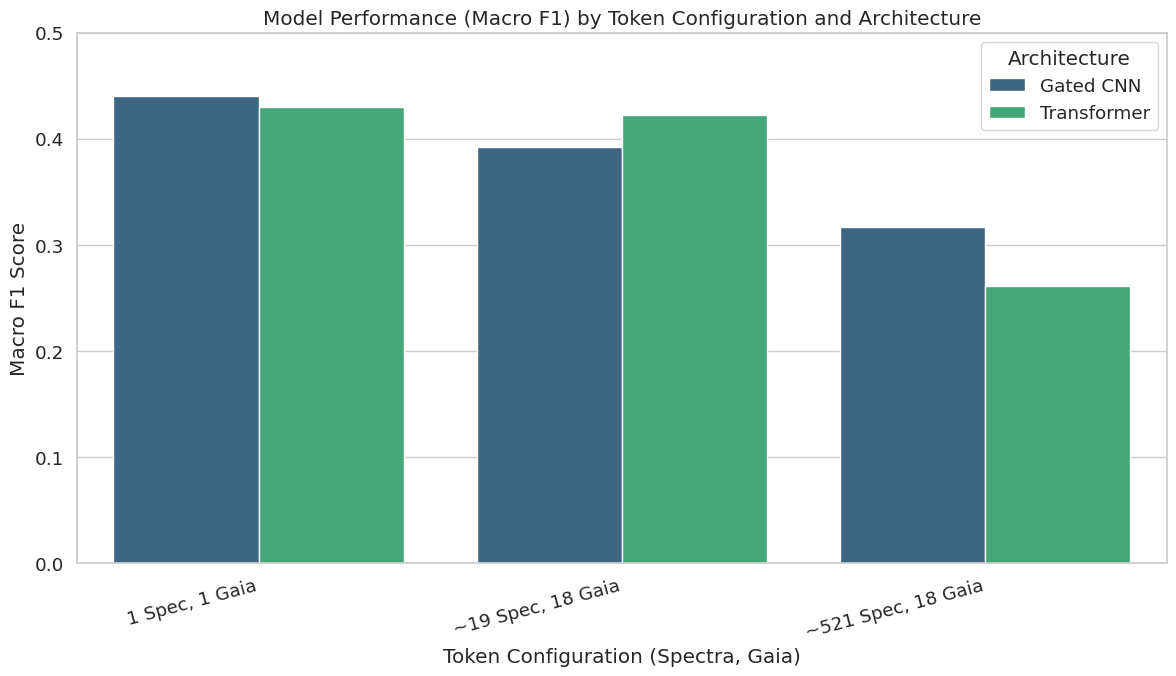

Saved: model_comparison_plots_20250520_131529/weighted_f1_vs_spectra_tokens_line.pdf


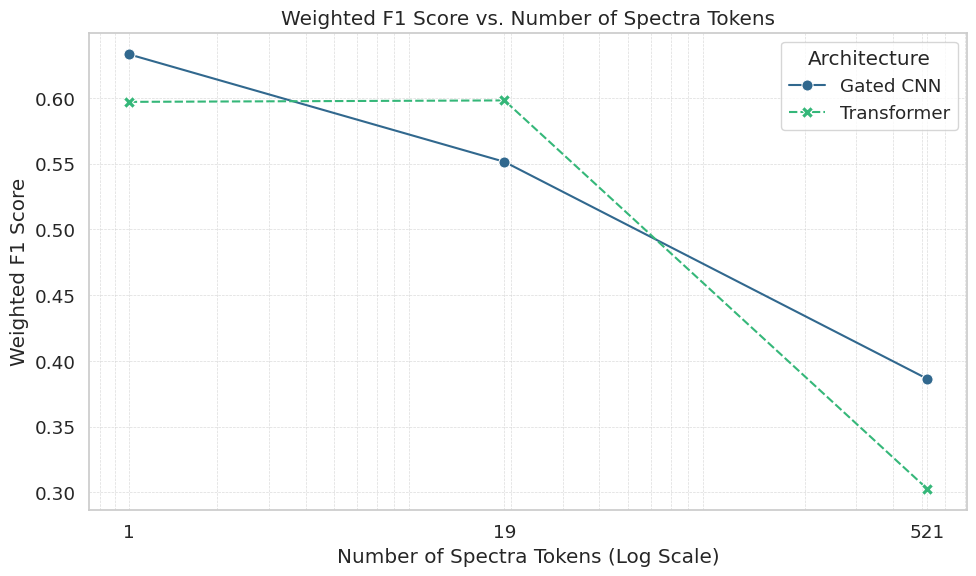

Saved: model_comparison_plots_20250520_131529/macro_precision_vs_spectra_tokens_line.pdf


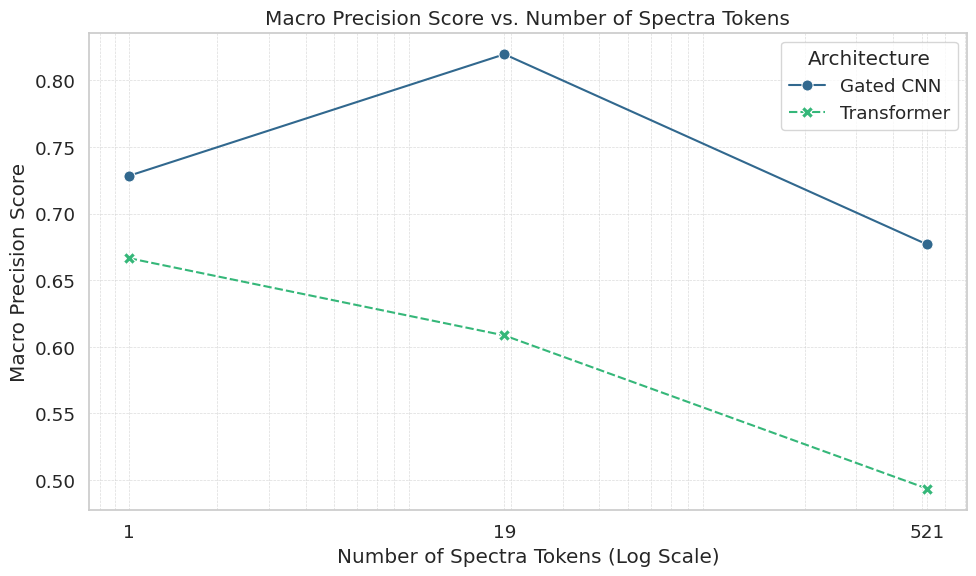

Saved: model_comparison_plots_20250520_131529/macro_recall_vs_spectra_tokens_line.pdf


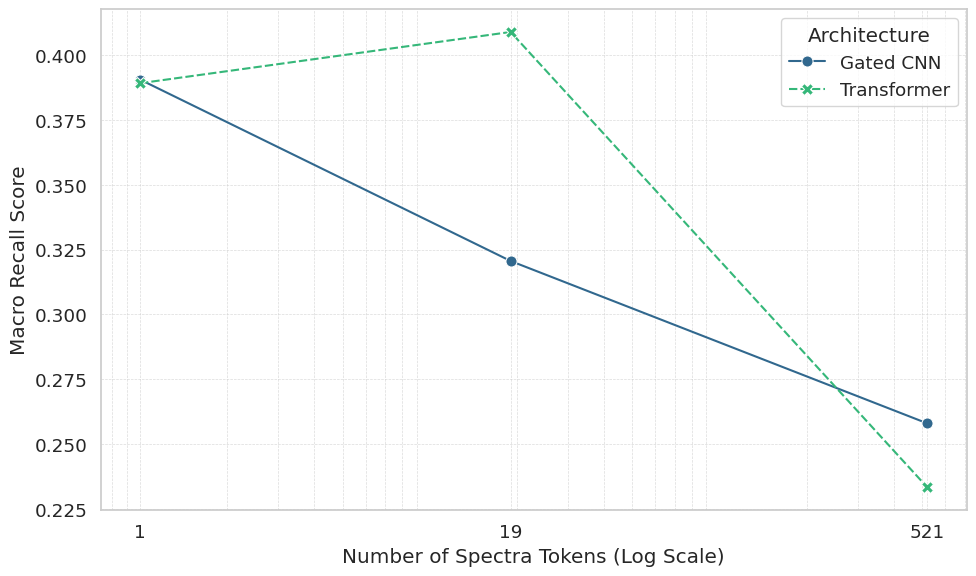

Saved: model_comparison_plots_20250520_131529/macro_auroc_vs_spectra_tokens_line.pdf


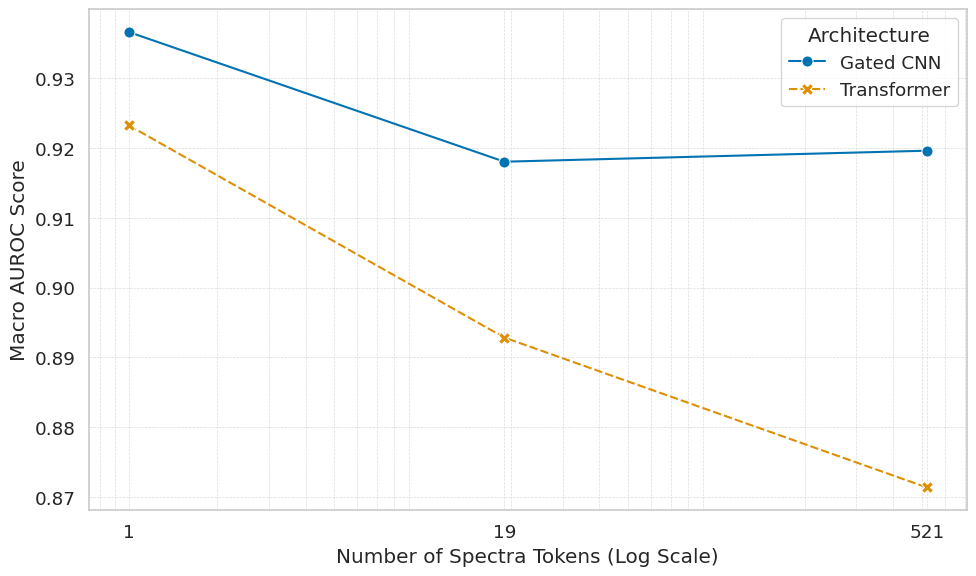

Saved: model_comparison_plots_20250520_131529/weighted_f1_vs_spectra_tokens_line.pdf


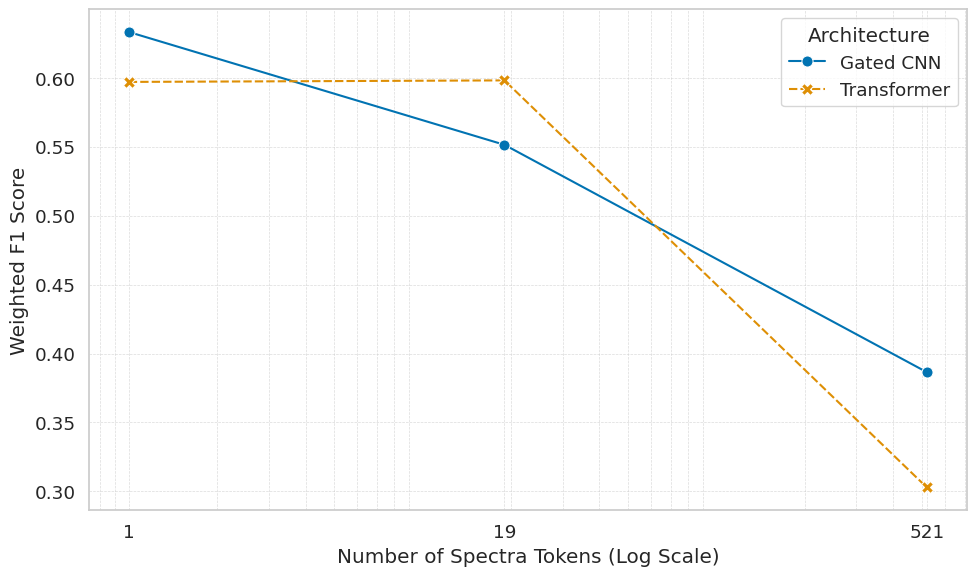


Plots saved in directory: model_comparison_plots_20250520_131529


In [4]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, roc_auc_score, average_precision_score
import os
import json
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import pickle
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score

# Assume Fusion_Models.py exists with the necessary classes
from Fusion_Models import StarClassifierFusionMambaOut, StarClassifierFusionTransformer


class MultiModalBalancedMultiLabelDataset(Dataset):
    """
    A balanced multi-label dataset that returns (X_spectra, X_gaia, y).
    It uses the same balancing strategy as `BalancedMultiLabelDataset`.
    """
    def __init__(self, X_spectra, X_gaia, y, limit_per_label=201):
        """
        Args:
            X_spectra (torch.Tensor): [num_samples, num_spectra_features]
            X_gaia (torch.Tensor): [num_samples, num_gaia_features]
            y (torch.Tensor): [num_samples, num_classes], multi-hot labels
            limit_per_label (int): limit or target number of samples per label
        """
        self.X_spectra = X_spectra
        self.X_gaia = X_gaia
        self.y = y
        self.limit_per_label = limit_per_label
        self.num_classes = y.shape[1] if y.ndim > 1 else 0 # Handle edge case
        if self.num_classes > 0:
             self.indices = self.balance_classes()
        else:
             # Handle case where y might be empty or 1D without classes defined
             print("Warning: Could not determine number of classes or y is empty.")
             self.indices = np.array([]) # Or handle appropriately

    def balance_classes(self):
        indices = []
        # Ensure y is 2D for sum operation
        y_2d = self.y
        if y_2d.ndim == 1:
             # This case shouldn't happen for multi-label, but as safeguard
             print("Warning: y seems to be 1D. Balancing might not work as expected.")
             # Attempt to convert or handle based on expected format
             # For now, proceed assuming it might have class indices if 1D
             # Or return empty if format is incorrect
             return np.array([]) # Or specific handling

        if y_2d.shape[0] == 0: # Handle empty y
             return np.array([])

        class_counts = torch.sum(y_2d, axis=0)
        for cls in range(self.num_classes):
            # Ensure y is numpy for np.where
            y_np = self.y.cpu().numpy() if isinstance(self.y, torch.Tensor) else self.y
            cls_indices = np.where(y_np[:, cls] == 1)[0]

            if len(cls_indices) == 0:
                # No samples for this class
                continue

            target_count = self.limit_per_label
            current_count = len(cls_indices)

            if current_count < target_count:
                # Oversample if fewer samples than limit
                extra_indices = np.random.choice(
                    cls_indices, target_count - current_count, replace=True
                )
                cls_indices = np.concatenate([cls_indices, extra_indices])
            elif current_count > target_count:
                # Undersample if more samples than limit
                cls_indices = np.random.choice(cls_indices, target_count, replace=False)
            # Else: current_count == target_count, use existing indices

            indices.extend(cls_indices)

        # Use unique indices and shuffle
        indices = np.unique(indices)
        np.random.shuffle(indices)
        return indices.astype(int) # Ensure indices are integers


    def re_sample(self):
        if self.num_classes > 0:
            self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
         if len(self.indices) == 0:
             raise IndexError("Dataset indices are empty.")
         # Ensure idx is within bounds
         if idx >= len(self.indices):
              raise IndexError(f"Index {idx} out of bounds for dataset with length {len(self.indices)}")

         index = self.indices[idx]
         # Ensure index is within bounds of the original data
         if index >= len(self.X_spectra):
              # This might indicate an issue with index generation or data mismatch
              print(f"Warning: Generated index {index} is out of bounds for X_spectra (len {len(self.X_spectra)}). Check balancing logic.")
              # Handle error: maybe skip this index, or raise an error
              # For now, let's raise an error to make the issue visible
              raise IndexError(f"Accessing index {index} failed, out of bounds for original data.")

         return (
             self.X_spectra[index],  # spectra features
             self.X_gaia[index],     # gaia features
             self.y[index],          # multi-hot labels
         )

def calculate_class_weights(y):
    y_np = y.cpu().numpy() if isinstance(y, torch.Tensor) else np.array(y) # Ensure numpy array
    if y_np.ndim > 1:
        class_counts = np.sum(y_np, axis=0)
    else: # Should not happen for multi-label, but handle
        class_counts = np.bincount(y_np)

    total_samples = y_np.shape[0]
    num_classes = y_np.shape[1] if y_np.ndim > 1 else len(class_counts)

    if num_classes == 0: return np.array([]) # Handle no classes

    # Prevent division by zero for classes with no samples
    class_counts = np.where(class_counts == 0, 1, class_counts)
    # Weight calculation: total_samples / (num_classes * count_per_class)
    class_weights = total_samples / (num_classes * class_counts)

    return class_weights

def calculate_metrics(y_true, y_pred):
    metrics = {
        "micro_f1": f1_score(y_true, y_pred, average='micro', zero_division=0),
        "macro_f1": f1_score(y_true, y_pred, average='macro', zero_division=0),
        "weighted_f1": f1_score(y_true, y_pred, average='weighted', zero_division=0),
        "micro_precision": precision_score(y_true, y_pred, average='micro', zero_division=0),
        "macro_precision": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "weighted_precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "micro_recall": recall_score(y_true, y_pred, average='micro', zero_division=0),
        "macro_recall": recall_score(y_true, y_pred, average='macro', zero_division=0),
        "weighted_recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "hamming_loss": hamming_loss(y_true, y_pred)
    }
    # Note: Setting zero_division=0 returns 0 for metrics where division by zero occurs (e.g., precision/recall when no samples are predicted for a class).

    return metrics


# --- Plotting Function ---
def generate_comparison_plots(results_df, results_dir):
    """Generates plots comparing model performance based on token size."""

    print("Generating comparison plots...")
    os.makedirs(results_dir, exist_ok=True)

    # --- Data Preparation for Plotting ---
    # Extract architecture and token config from model name index
    results_df['architecture'] = results_df.index.map(lambda x: x.split('_')[0])
    results_df['token_config_str'] = results_df.index.map(lambda x: '_'.join(x.split('_')[1:]))

    # If MambaOut models are present, rename them to Gated CNN
    results_df['architecture'] = results_df['architecture'].replace({'MambaOut': 'Gated CNN'})

    # Define a categorical order for token configurations for consistent plotting
    token_order = ['1token', '19_18token', '522_18token']
    results_df['token_config_cat'] = pd.Categorical(
        results_df['token_config_str'], categories=token_order, ordered=True
    )

    # Sort dataframe for consistent plot ordering
    results_df = results_df.sort_values(by=['architecture', 'token_config_cat'])

    # Map token config strings to shorter labels for plots
    token_labels = {
        '1token': '1 Spec, 1 Gaia',
        '19_18token': '~19 Spec, 18 Gaia',
        '522_18token': '~521 Spec, 18 Gaia'
    }
    results_df['token_label'] = results_df['token_config_str'].map(token_labels)
    label_order = [token_labels[t] for t in token_order]


    # --- Plot 1: Grouped Bar Chart (Macro F1 vs Token Config by Architecture) ---
    plt.figure(figsize=(12, 7))
    sns.set(font_scale=1.2, style='whitegrid')
    sns.barplot(
        data=results_df,
        x='token_label',
        y='macro_f1',
        hue='architecture',
        order=label_order, # Use the mapped labels in the correct order
        palette='viridis'
    )
    plt.xlabel("Token Configuration (Spectra, Gaia)")
    plt.ylabel("Macro F1 Score")
    plt.title("Model Performance (Macro F1) by Token Configuration and Architecture")
    plt.ylim(0, max(results_df['macro_f1'].max() * 1.1, 0.5)) # Adjust ylim for better visualization
    plt.xticks(rotation=15, ha='right')
    plt.legend(title="Architecture")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "macro_f1_vs_token_config_grouped.pdf"))
    print(f"Saved: {os.path.join(results_dir, 'macro_f1_vs_token_config_grouped.pdf')}")
    plt.show()
    plt.close()

    # --- Plot 2: Line Plot (Macro F1 vs Spectra Tokens by Architecture) ---
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df,
        x='spectra_tokens',
        y='weighted_f1',
        hue='architecture',
        style='architecture', # Different line styles
        markers=True,         # Show points
        markersize=8,
        palette='viridis'
    )
    # Use log scale for x-axis because token counts are far apart
    plt.xscale('log')
    plt.xlabel("Number of Spectra Tokens (Log Scale)")
    plt.ylabel("Weighted F1 Score")
    plt.title("Weighted F1 Score vs. Number of Spectra Tokens")
    plt.xticks(results_df['spectra_tokens'].unique(), labels=results_df['spectra_tokens'].unique()) # Label specific points
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title="Architecture")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "weighted_f1_vs_spectra_tokens_line.pdf"))
    print(f"Saved: {os.path.join(results_dir, 'weighted_f1_vs_spectra_tokens_line.pdf')}")
    plt.show()
    plt.close()

    # --- Plot 3: Line Plot (Precision vs Spectra Tokens by Architecture) ---
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df,
        x='spectra_tokens',
        y='macro_precision',
        hue='architecture',
        style='architecture', # Different line styles
        markers=True,         # Show points
        markersize=8,
        palette='viridis'
    )
    # Use log scale for x-axis because token counts are far apart
    plt.xscale('log')
    plt.xlabel("Number of Spectra Tokens (Log Scale)")
    plt.ylabel("Macro Precision Score")
    plt.title("Macro Precision Score vs. Number of Spectra Tokens")
    plt.xticks(results_df['spectra_tokens'].unique(), labels=results_df['spectra_tokens'].unique()) # Label specific points
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title="Architecture")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "macro_precision_vs_spectra_tokens_line.pdf"))
    print(f"Saved: {os.path.join(results_dir, 'macro_precision_vs_spectra_tokens_line.pdf')}")
    plt.show()

    # --- Plot 4: Line Plot (Recall vs Spectra Tokens by Architecture) ---
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df,
        x='spectra_tokens',
        y='macro_recall',
        hue='architecture',
        style='architecture', # Different line styles
        markers=True,         # Show points
        markersize=8,
        palette='viridis'
    )
    # Use log scale for x-axis because token counts are far apart
    plt.xscale('log')
    plt.xlabel("Number of Spectra Tokens (Log Scale)")
    plt.ylabel("Macro Recall Score")
    plt.xticks(results_df['spectra_tokens'].unique(), labels=results_df['spectra_tokens'].unique()) # Label specific points
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title="Architecture")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "macro_recall_vs_spectra_tokens_line.pdf"))
    print(f"Saved: {os.path.join(results_dir, 'macro_recall_vs_spectra_tokens_line.pdf')}")
    plt.show()
    plt.close()

    # --- Plot 5: Line Plot (AUROC vs Spectra Tokens by Architecture) ---
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df,
        x='spectra_tokens',
        y='macro_auroc',
        hue='architecture',
        style='architecture', # Different line styles
        markers=True,         # Show points
        markersize=8,
        palette='colorblind' # Use colorblind-friendly palette
    )
    # Use log scale for x-axis because token counts are far apart
    plt.xscale('log')
    plt.xlabel("Number of Spectra Tokens (Log Scale)")
    plt.ylabel("Macro AUROC Score")
    plt.xticks(results_df['spectra_tokens'].unique(), labels=results_df['spectra_tokens'].unique()) # Label specific points
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title="Architecture")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "macro_auroc_vs_spectra_tokens_line.pdf"))
    print(f"Saved: {os.path.join(results_dir, 'macro_auroc_vs_spectra_tokens_line.pdf')}")
    plt.show()
    plt.close()

    # --- Plot 6: Line Plot (Weighted F1 vs Spectra Tokens by Architecture) ---
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=results_df,
        x='spectra_tokens',
        y='weighted_f1',
        hue='architecture',
        style='architecture', # Different line styles
        markers=True,         # Show points
        markersize=8,
        palette='colorblind' # Use colorblind-friendly palette
    )
    # Use log scale for x-axis because token counts are far apart
    plt.xscale('log')
    plt.xlabel("Number of Spectra Tokens (Log Scale)")
    plt.ylabel("Weighted F1 Score")
    plt.xticks(results_df['spectra_tokens'].unique(), labels=results_df['spectra_tokens'].unique()) # Label specific points
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title="Architecture")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "weighted_f1_vs_spectra_tokens_line.pdf"))
    print(f"Saved: {os.path.join(results_dir, 'weighted_f1_vs_spectra_tokens_line.pdf')}")
    plt.show()
    plt.close()

# --- Main Execution ---
if __name__ == "__main__":
    # Option 1: Run the full evaluation (if you uncomment the original main)
    # print("Running full evaluation...")
    # main() # This would generate the results file

    print("Loading results and generating plots...")
    results_dir = f"model_comparison_plots_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    csv_file = "model_comparison_results.csv" # Assumes the CSV from your run exists

    if not os.path.exists(csv_file):
        print(f"'{csv_file}' not found.")
        # Attempt to find a CSV in a timestamped directory if needed
        # Example: Search for the latest results directory
        potential_dirs = sorted([d for d in os.listdir('.') if d.startswith('model_comparison_2') and os.path.isdir(d)], reverse=True)
        found_csv = False
        if potential_dirs:
             latest_dir = potential_dirs[0]
             potential_csv = os.path.join(latest_dir, "model_comparison_results.csv")
             if os.path.exists(potential_csv):
                  csv_file = potential_csv
                  print(f"Found results CSV in: {csv_file}")
                  found_csv = True
        results_df = pd.read_csv(csv_file, index_col='model_name')
    else:
        results_df = pd.read_csv(csv_file, index_col='model_name')


    # Correct spectra tokens calculation based on parameters (more robust)
    # This assumes the parameters used were exactly as listed in the original script
    token_params = {
        "MambaOut_1token": (3647, 3647), "MambaOut_19_18token": (3647, 192), "MambaOut_522_18token": (3647, 7),
        "Transformer_1token": (3647, 3647), "Transformer_19_18token": (3647, 192), "Transformer_522_18token": (3647, 7),
    }
    corrected_spectra_tokens = {}
    for name, params in token_params.items():
        if name in results_df.index:
            input_dim, token_dim = params
            tokens = (input_dim + token_dim - 1) // token_dim # Ceiling division
            corrected_spectra_tokens[name] = tokens

    results_df['spectra_tokens'] = results_df.index.map(corrected_spectra_tokens)
    # Recalculate total tokens if needed
    # results_df['total_tokens'] = results_df['spectra_tokens'] + results_df['gaia_tokens']

    print("\nResults DataFrame Head:")
    print(results_df.head())

    generate_comparison_plots(results_df, results_dir)

    print(f"\nPlots saved in directory: {results_dir}")